In [2]:
from qiskit.circuit.library import EfficientSU2

num_qubits=50
reps=2
abstract_circuit=EfficientSU2(num_qubits,reps=reps,entanglement="pairwise")

In [3]:
abstract_circuit.num_parameters

300

In [4]:
import numpy as np
num_parameters=abstract_circuit.num_parameters 
param_values=np.random.uniform(-np.pi,np.pi,size=num_parameters)
abstract_circuit.assign_parameters(param_values,inplace=True)

In [5]:
from qiskit.circuit.library import UnitaryOverlap

abstract_circuit.barrier()

abstract_circuit=UnitaryOverlap(abstract_circuit,abstract_circuit)


In [6]:
from qiskit.quantum_info import SparsePauliOp 

paulis=["".join ("Z" if i==q else "I" for i in range (num_qubits)) for q in range(num_qubits)]

abstract_observables=[SparsePauliOp(pauli) for pauli in paulis]

(abstract_observables)

[SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService 

service=QiskitRuntimeService()
backend=service.least_busy(operational=True,simulator=False)
backend.name

'ibm_osaka'

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 
pm=generate_preset_pass_manager(backend=backend,optimization_level=3)
target_circuit=pm.run(abstract_circuit)

In [15]:
layout=target_circuit.layout
target_observables=[abs_ops.apply_layout(layout=layout)for abs_ops in abstract_observables]

In [11]:
from qiskit_ibm_runtime.options import DynamicalDecouplingOptions, ResilienceOptionsV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator,EstimatorOptions,Batch

In [12]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [53]:
pub=(target_circuit,target_observables)
count=1
primitive_result=[]
default_shots=10_000
with Batch(backend=backend) as batch:
    options_ex1=EstimatorOptions()
    options_ex1.optimization_level=0
    options_ex1.resilience_level=0
    options_ex1.default_shots=default_shots

    estimator=Estimator(backend=backend,options=options_ex1)
    job_ex1=estimator.run(pubs=[pub])
    
    print(f"Job Id for type {count} error mitigation:: {job_ex1.job_id()}")
    count+=1

    options_ex2=EstimatorOptions()
    options_ex2.default_shots=default_shots 
    options_ex2.optimization_level=0
    options_ex2.resilience_level=0
    dd_options=DynamicalDecouplingOptions()
    dd_options.enable=True 
    dd_options.sequence_type="XX"
    options_ex2.dynamical_decoupling=dd_options 

    estimator=Estimator(options=options_ex2)
    job_ex2=estimator.run(pubs=[pub])

    print(f"Job Id for type {count} error mitigation:: {job_ex2.job_id()}")
    count+=1


    options_ex3=EstimatorOptions()
    options_ex3.default_shots=default_shots 
    options_ex3.optimization_level=0
    options_ex3.resilience_level=0
    resilience_options=ResilienceOptionsV2()
    resilience_options.measure_mitigation=True 
    options_ex3.resilience=resilience_options 

    estimator=Estimator(options=options_ex3)
    job_ex3=estimator.run(pubs=[pub])

    print(f"Job Id for type {count} error mitigation:: {job_ex3.job_id()}")
    count+=1

C:\Users\Rajat\AppData\Local\Temp\ipykernel_5852\1943716905.py:12: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator=Estimator(backend=backend,options=options_ex1)


Job Id for type 1 error mitigation:: ctcjx8dzw920008dh3tg
Job Id for type 2 error mitigation:: ctcjx9xxgmhg0082zzzg
Job Id for type 3 error mitigation:: ctcjxbdzw920008dh3wg


In [13]:
job_ex1=service.job("ctcjx8dzw920008dh3tg")
job_ex2=service.job("ctcjx9xxgmhg0082zzzg")
job_ex3=service.job("ctcjxbdzw920008dh3wg")

In [14]:
import matplotlib.pyplot as plt 
average_expectation_values=[]
primitive_results=[]
primitive_results.append(job_ex1.result())
primitive_results.append(job_ex2.result())
primitive_results.append(job_ex3.result())



for result in primitive_results:
    pub_result=result[0]
    avg_expectation_value=sum(pub_result.data.evs)/len(pub_result.data.evs)
    average_expectation_values.append(avg_expectation_value)

In [15]:
average_expectation_values

[0.5871439999999999, 0.5740879999999998, 0.6177175772988336]

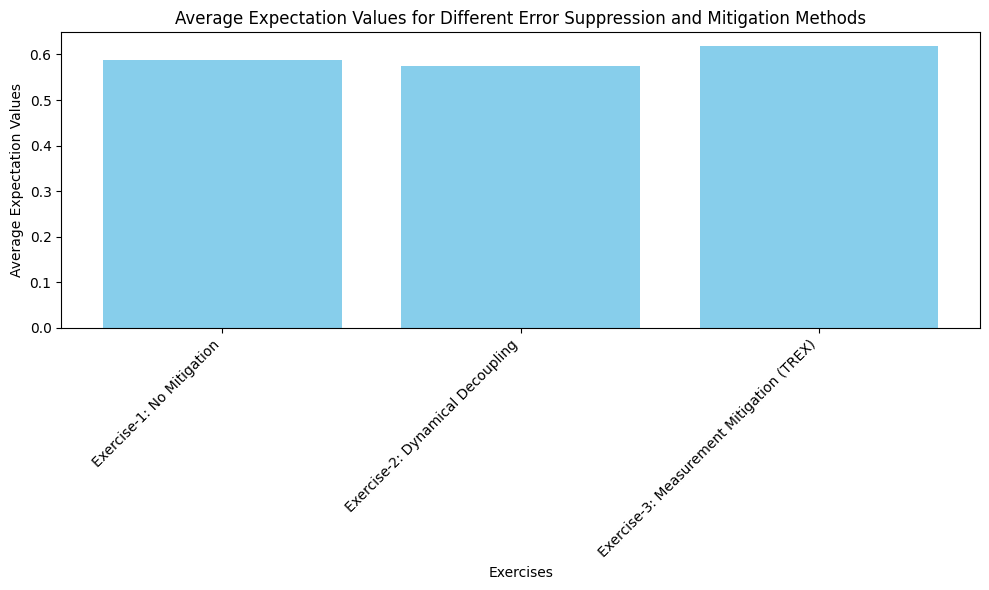

In [16]:
exercise_labels = [
    "Exercise-1: No Mitigation",
    "Exercise-2: Dynamical Decoupling",
    "Exercise-3: Measurement Mitigation (TREX)",
]
plt.figure(figsize=(10, 6))
plt.bar(exercise_labels, average_expectation_values, color='skyblue')
plt.xlabel('Exercises')
plt.ylabel('Average Expectation Values')
plt.title('Average Expectation Values for Different Error Suppression and Mitigation Methods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [32]:
from qiskit_ibm_runtime.options import DynamicalDecouplingOptions, ResilienceOptionsV2, ZneOptions, TwirlingOptions
pub=(target_circuit,target_observables)
default_shots=10_000
count=4
with Batch(backend=backend) as batch:
    options_ex4a = EstimatorOptions(default_shots=default_shots,optimization_level=0,resilience_level=0)
    options_ex4a.resilience.zne_mitigation=True
    options_ex4a.resilience.zne.extrapolator = 'exponential'
    options_ex4a.resilience.zne.noise_factors=(1,3,5)

    estimator=Estimator(options=options_ex4a)
    job=estimator.run(pubs=[pub])

    print(f"Job Id for type {count} error mitigation:: {job.job_id()}")
    count+=1

    options_ex4b = EstimatorOptions(default_shots=default_shots,optimization_level=0,resilience_level=0)
    options_ex4b.resilience.zne_mitigation=True
    options_ex4b.resilience.zne.extrapolator = 'linear'
    options_ex4b.resilience.zne.noise_factors=(1,3,5)

    estimator = Estimator(options=options_ex4b)
    job = estimator.run(pubs=[pub]) 

    print(f"Job Id for type {count} error mitigation:: {job.job_id()}")
    count+=1
    # Exercise-5: Gate Twirling + Zero Noise Extrapolation (use: extrapolator=("exponential", "linear") and noise_factors=(1, 3, 5))
    options_ex5 = EstimatorOptions(default_shots=default_shots,optimization_level=0,resilience_level=0)
    options_ex5.resilience.zne_mitigation=True
    options_ex5.resilience.zne.extrapolator = ('exponential',"linear")
    options_ex5.resilience.zne.noise_factors=(1,3,5)

    twirling_options = TwirlingOptions()
    twirling_options.enable_gates = True
    twirling_options.enable_measure= False
    twirling_options.num_randomizations="auto"
    twirling_options.shots_per_randomization='auto'
    twirling_options.strategy='active-accum'

    resilience_options = ResilienceOptionsV2()
    resilience_options.measure_mitigation = False
    options_ex5.twirling = twirling_options
    options_ex5.resilience = resilience_options
    
    # Instantiate `Estimator` with options
    estimator = Estimator(options=options_ex5)
    job= estimator.run(pubs=[pub])
    
    print(f"Job Id for type {count} error mitigation:: {job.job_id()}")
    count+=1

Job Id for type 4 error mitigation:: ctcntxkzw920008dhp7g
Job Id for type 5 error mitigation:: ctcntyvxgmhg00830k4g
Job Id for type 6 error mitigation:: ctcnv04zw920008dhp80


In [34]:
job_ex4a=service.job("ctcntxkzw920008dhp7g")
job_ex4b=service.job("ctcntyvxgmhg00830k4g")
job_ex5=service.job("ctcnv04zw920008dhp80")

primitive_results.append(job_ex4a.result())
primitive_results.append(job_ex4b.result())
primitive_results.append(job_ex5.result())

In [36]:
len(primitive_results)

6

In [48]:
pub=(target_circuit,target_observables)
default_shots=10_000

In [49]:
options_ex6=EstimatorOptions(default_shots=default_shots,optimization_level=0,resilience_level=0)

dd_options=DynamicalDecouplingOptions()
dd_options.enable=True 
dd_options.sequence_type="XX" 

options_ex6.dynamical_decoupling=dd_options 

options_ex6.resilience.zne_mitigation=True 
options_ex6.resilience.zne.extrapolator = ('exponential',"linear")
options_ex6.resilience.zne.noise_factors=(1,3,5)

twirling_options=TwirlingOptions()
twirling_options.enable_gates=True 
twirling_options.enable_measure=False 
resilience_options=ResilienceOptionsV2()

resilience_options.measure_mitigation=True 


options_ex6.twirling=twirling_options 
options_ex6.resilience=resilience_options 

estimator=Estimator(mode=backend,options=options_ex6)
job_ex6=estimator.run(pubs=[pub])


print(f"Job Id for type {count} error mitigation technique:: {job_ex6.job_id()}")
primitive_results.append(job_ex6.result())

Job Id for type 7 error mitigation technique:: ctcp5341zwrg008j4vh0


In [53]:
exercise_labels = [
    "No Mitigation",
    "DD",
    "Measurement Mitigation (TREX)",
    "ZNE (Exponential)",
    "ZNE (Linear)",
    "Gate Twirling + ZNE",
    "Exercise-6: All"
]

In [51]:
len(primitive_results)

7

In [56]:
average_expectation_values=[]
for result in primitive_results:
    pub_result=result[0]
    avg_expectation_value=sum(pub_result.data.evs)/len(pub_result.data.evs)
    average_expectation_values.append(avg_expectation_value)

In [57]:
average_expectation_values

[0.5871439999999999,
 0.5740879999999998,
 0.6177175772988336,
 8.702863568961215,
 0.7888120932744109,
 0.692767571884984,
 0.6944617443553885]

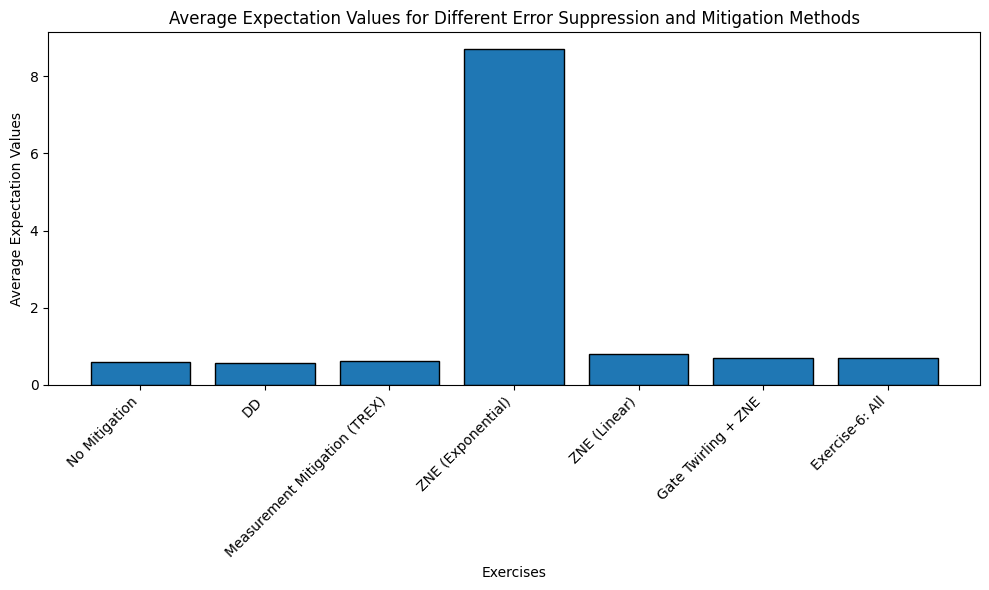

In [59]:
plt.figure(figsize=(10, 6))
plt.bar(exercise_labels, average_expectation_values,edgecolor="black")
plt.xlabel('Exercises')
plt.ylabel('Average Expectation Values')
plt.title('Average Expectation Values for Different Error Suppression and Mitigation Methods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
from qiskit_ibm_runtime import SamplerV2 as Sampler,Options
options=Sampler.options

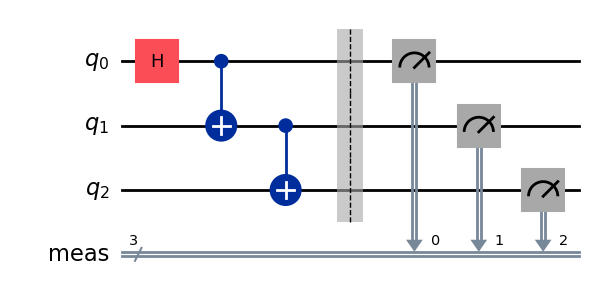

In [22]:
from qiskit import QuantumCircuit
BellCircuit=QuantumCircuit(3)

BellCircuit.h(0)
for i in range (0,BellCircuit.num_qubits-1):
    BellCircuit.cx(i,i+1)

BellCircuit.measure_all()
BellCircuit.draw(output="mpl")

In [24]:
preset_pass=generate_preset_pass_manager(
    backend=backend,
    optimization_level=3,
)
isa_circuit=preset_pass.run(BellCircuit)
options.dynamical_decoupling.enable=True 
options.twirling.enable_gates=True 

sampler=Sampler(backend=backend,options=options)

job_sampler=sampler.run([isa_circuit])
print(f"Job Id for the Sampler Job: {job_sampler.job_id()}")

result=job_sampler.result()[0]
counts=result.data.meas.get_counts()


AttributeError: 'property' object has no attribute 'dynamical_decoupling'

In [27]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, Options
sampler=Sampler(backend=backend)
# Estimator and Sampler now have different options
options = sampler.options
 
options.dynamical_decoupling.enable = True
# Turn on gate twirling. Requires qiskit_ibm_runtime 0.23.0 or later.
options.twirling.enable_gates = True
 
print(f">>> dynamical decoupling is turned on: {sampler.options.dynamical_decoupling.enable}")
print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")
 

>>> dynamical decoupling is turned on: True
>>> gate twirling is turned on: True


C:\Users\Rajat\AppData\Local\Temp\ipykernel_11800\3979727092.py:2: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler=Sampler(backend=backend)


In [28]:
job_sampler=sampler.run([isa_circuit])
print(f"Job Id for the Sampler Job: {job_sampler.job_id()}")

result=job_sampler.result()[0]
counts=result.data.meas.get_counts()


Job Id for the Sampler Job: ctd50maakxxg008kfg7g


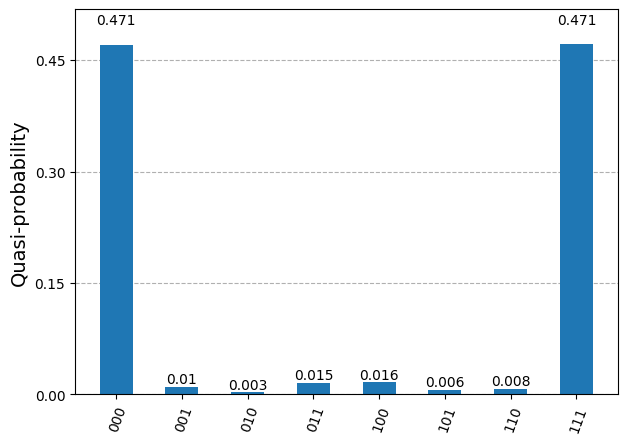

In [29]:
from qiskit.visualization import plot_distribution 

plot_distribution(counts)

In [33]:
sampler=Sampler(mode=backend)
# Estimator and Sampler now have different options
options = sampler.options

options.dynamical_decoupling.enable = False
# Turn on gate twirling. Requires qiskit_ibm_runtime 0.23.0 or later.
options.twirling.enable_gates = False
 
print(f">>> dynamical decoupling is turned on: {sampler.options.dynamical_decoupling.enable}")
print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")
 

>>> dynamical decoupling is turned on: False
>>> gate twirling is turned on: False


In [34]:
job_normal=sampler.run([isa_circuit])
print(f"Job Id for the Sampler Job: {job_normal.job_id()}")

result_normal=job_normal.result()[0]
counts_normal=result_normal.data.meas.get_counts()


Job Id for the Sampler Job: ctd51zzy6ybg008tntb0


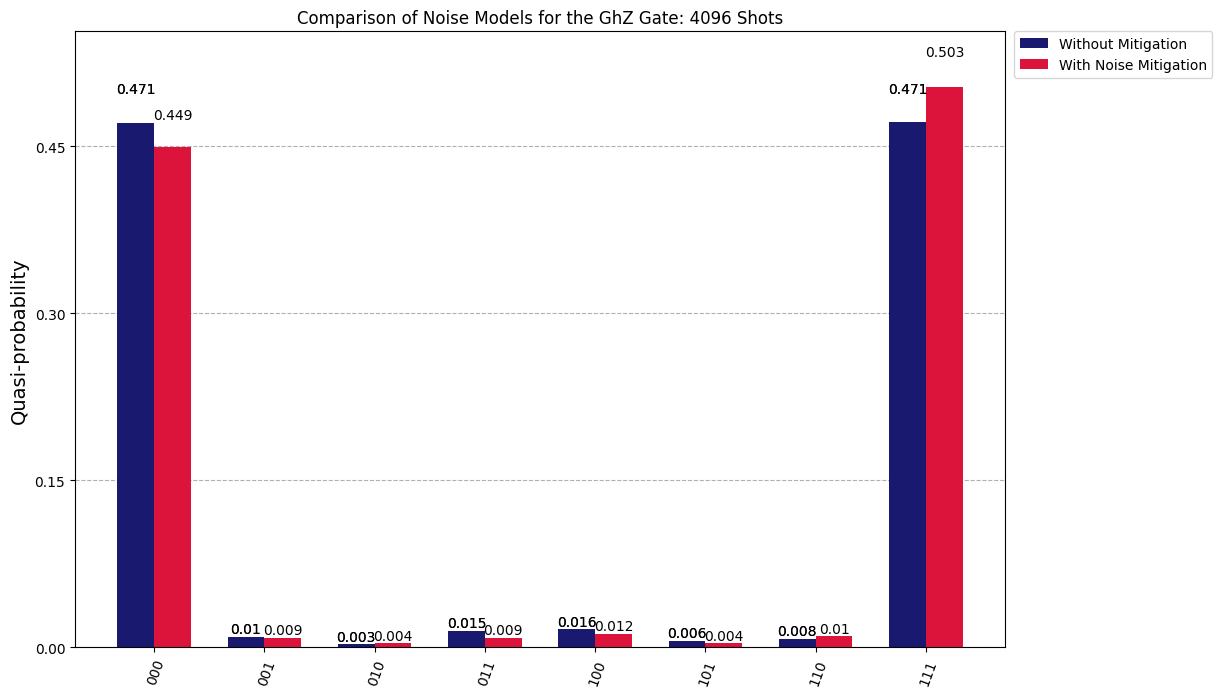

In [36]:
from qiskit.visualization import plot_histogram 

plot_distribution(
    [counts,counts_normal],
    figsize=(12,8),
    color=["MidnightBlue","Crimson"],
    legend=["Without Mitigation","With Noise Mitigation"],
    title="Comparison of Noise Models for the GhZ Gate: 4096 Shots"
)